# Split into 500 and 330 group, find features on 500 and test on 330

models: Linear, LASSO, MLP, LatSim + Correlation Top 10 both 5 positive + 5 negative
task: rest, nback, emoid
preproc: FC, PC

In [1]:
import pickle
from natsort import natsorted

basedir = '../../ImageNomer/data/anton/cohorts/test'
demoname = f'{basedir}/demographics.pkl'

with open(demoname, 'rb') as f:
    demo = pickle.load(f)
    
subs = natsorted(list(demo['wrat'].keys()))
print(len(subs))

830


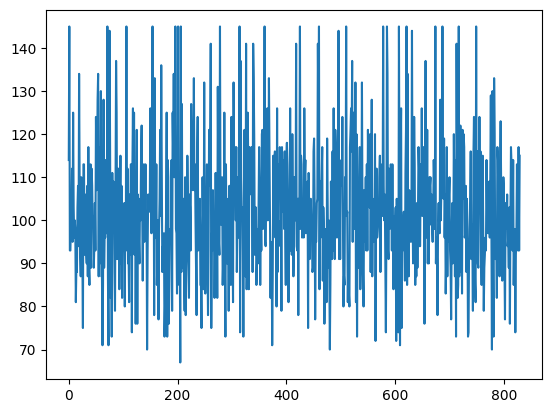

In [2]:
import matplotlib.pyplot as plt

plt.plot([demo['wrat'][sub] for sub in subs])
plt.show()

In [504]:
import numpy as np
from sklearn.decomposition import PCA

task = 'nback'
pre = 'fc'
sset = 'big'

# Load FC 

fcs = []
ages = []
ea_idcs = []
aa_idcs = []
i = 0

for sub in subs:
    fname = f'{basedir}/{pre}/{sub}_task-{task}_{pre}.npy'
#     fname = f'{basedir}/decomp/{task}-weights/{sub}_comp-{task}_weights.npy'
#     if demo['race'][sub] != 'EA':
#         continue
#         ea_idcs.append(i)
#         i += 1
#     elif demo['race'][sub] == 'AA':
#         aa_idcs.append(i)
#         i += 1
#     else:
#         continue
#     fname = f'{basedir}/snps/{sub}_set-{sset}_snps.npy'
    fc = np.load(fname)
#     x0 = fc == 0
#     x1 = fc == 1
#     x2 = fc == 2
#     fc = np.concatenate([x0,x1,x2])
    fcs.append(fc)
    ages.append(demo['wrat'][sub])
    
fcs = np.stack(fcs)
# fcs[:,np.where(np.sum(fcs[:250],axis=0) < 50)[0]] = 0
# fcs = fcs[:,np.where(np.sum(fcs,axis=0) > 50)[0]]

# pca = PCA().fit(fcs[:250])
# fcs = pca.transform(fcs)
    
ages = np.array(ages)
# mu_ea = np.mean(ages[ea_idcs])
# mu_aa = np.mean(ages[aa_idcs])
# ages[ea_idcs] = ages[ea_idcs] - mu_ea
# ages[aa_idcs] = ages[aa_idcs] - mu_aa
print(fcs.shape)
print(ages.shape)
print(ages[0:3])
# print(mu_ea)
# print(mu_aa)

(830, 34716)
(830,)
[114 145  93]


In [480]:
# Correlation

ntrain = 700

x = fcs[:ntrain]
mux = np.mean(x, axis=0, keepdims=True)
x = x - mux
y = ages[:ntrain]
muy = np.mean(y)
y = y - muy
xx = np.einsum('ab,ab->b',x,x)
yy = np.einsum('a,a->',y,y)
xy = np.einsum('ab,a->b',x,y)
rho = xy / (xx*yy)**0.5
rho[np.isnan(rho)] = 0

idcs = np.argsort(rho)
bot_idcs = idcs[0:5]
top_idcs = idcs[-5:]
print('Done')
print(rho[bot_idcs])
print(rho[top_idcs])

Done
[-0.19926055 -0.19846727 -0.18034447 -0.17988202 -0.17986289]
[0.16105329 0.16511303 0.16780931 0.16927623 0.18531208]


In [487]:
# Test correlation

from sklearn.linear_model import Ridge

sav_idcs = np.concatenate([bot_idcs, top_idcs])
print(sav_idcs)

ntrain = 700

xtr = fcs[:ntrain]#[:,sav_idcs]
xt = fcs[ntrain:]#[:,sav_idcs]

ytr = ages[:ntrain]
yt = ages[ntrain:]

muy = np.mean(ytr)
ytr = ytr - muy
yt = yt - muy

reg = Ridge(alpha=10000,fit_intercept=False).fit(xtr, ytr)
yhat = reg.predict(xt)

print(np.mean((yhat-yt)**2)**0.5)
print(np.mean((np.mean(yt)-yt)**2)**0.5)

[ 7910 25837 26483 26484 19732 21041  6730 23693 25588 18818]
14.662085757238827
15.18202962942172


In [494]:
# Linear

from sklearn.linear_model import Lasso

ntrain = 700
nn = 600
rs = []
coef = []

for i in range(20):
    idcs = np.random.permutation(ntrain)
    x = fcs[:ntrain]
    x = x[idcs]
    xtr = x[:nn]
    xt = x[nn:]

    y = ages[:ntrain]
    y = y[idcs]
    ytr = y[:nn]
    yt = y[nn:]
    
    muy = np.mean(ytr)
    ytr = ytr - muy
    yt = yt - muy

    reg = Lasso(alpha=0.5,max_iter=1000,fit_intercept=False).fit(xtr, ytr)
#     reg = Ridge(alpha=10000,fit_intercept=False).fit(xtr, ytr)
    yhat = reg.predict(xt)
    rmse = np.mean((yhat-yt)**2)**0.5
    rmse = float(rmse)
    print(rmse)
    rs.append(rmse)
    coef.append(reg.coef_*np.mean(xtr, axis=0))
    rmse = np.mean((np.mean(yt)-yt)**2)**0.5
    rmse = float(rmse)
    print(rmse)
    
print('---')
print(np.mean(rs))
print(np.std(rs))
yt = ages[:ntrain]
print(np.mean((np.mean(yt)-yt)**2)**0.5)
# idcs = np.argsort(np.abs(reg.coef_))[-10:]
# print(idcs)
# reg.coef_[idcs]

17.630262211172095
17.9394091318527
14.958050714788776
15.180681802870383
14.950476608587463
15.173213239126378
19.33436386361566
18.886659312858907
15.725927064960821
16.339678699411444
16.573633101433963
16.704598169366424
13.968898511090378
14.472301130089852
13.9726196041112
14.240519653439618
16.833720760473227
17.331658893481602
13.509064353971224
13.92297022908546
14.487611658648387
14.857994481086605
15.082469196211461
15.312596122147282
14.148154947075762
14.454563293299456
13.026686772366904
13.077503584400196
15.714368958172493
16.083317443860892
16.37233100070281
16.79816656662268
14.481429425784881
14.608144988327574
17.080633099374875
17.168840962627616
14.070422829940792
14.50999655410021
15.02817130637165
15.508768487536333
---
15.347464799442742
1.5288456303162548
15.956339409367638


In [495]:
cc = np.stack(coef)
cc = np.mean(cc, axis=0)
# idcs = np.argsort(cc)
idcs = np.argsort(np.abs(cc))[-10:]
# idcs = np.concatenate([idcs[:5], idcs[-5:]])
print(idcs)
print(cc[idcs])

[ 2569 19732 17930 17356 23693 25588 18818 26032 25837  7910]
[ 0.26263316 -0.27214944  0.29580216 -0.34854607  0.37686885  0.43476662
  0.55965771  0.68037149 -0.80846758 -1.04655317]


In [499]:
# Test linear

ntrain = 700

xtr = fcs[:ntrain][:,idcs]
xt = fcs[ntrain:][:,idcs]

ytr = ages[:ntrain]
yt = ages[ntrain:]

muy = np.mean(ytr)
ytr = ytr - muy
yt = yt - muy

reg = Ridge(alpha=100,fit_intercept=False).fit(xtr, ytr)
yhat = reg.predict(xt)
rmse = np.mean((yhat-yt)**2)**0.5
rmse = float(rmse)
print(rmse)
rmse = np.mean((np.mean(yt)-yt)**2)**0.5
rmse = float(rmse)
print(rmse)

15.286714957935764
15.18202962942172


In [351]:
reg.coef_

array([-3657.796 , -1838.8344, -2061.6082, -3549.03  , -4862.9214,
        2681.03  ,   921.5452,  4463.8643,  1111.3763,   645.9765],
      dtype=float32)

In [506]:
from sklearn.linear_model import Ridge, LinearRegression

# Greedy selection

ntrain = 700

x = fcs[:ntrain]
mux = np.mean(x, axis=0, keepdims=True)
x = x - mux

r = ages[:ntrain]
sel_idcs = []

for i in range(10):
    mur = np.mean(r)
    r = r - mur
    xx = np.einsum('ab,ab->b',x,x)
    rr = np.einsum('a,a->',r,r)
    xr = np.einsum('ab,a->b',x,r)
    rho = xr / (xx*rr)**0.5
    rho[np.isnan(rho)] = 0

    idcs = np.argsort(np.abs(rho))[::-1]
    for j in range(10):
        if idcs[j] not in sel_idcs:
            sel_idcs.append(idcs[j])
            break
            
    xtr = fcs[:ntrain][:,sel_idcs]
    xt = fcs[ntrain:][:,sel_idcs]
    
#     mux = np.mean(xtr, axis=0, keepdims=True)
#     xtr = xtr - mux
#     xt = xt - mux
    
    ytr = ages[:ntrain]
    yt = ages[ntrain:]
    
    muy = np.mean(ytr)
    ytr = ytr - muy
    yt = yt - muy
    
    print(sel_idcs)
    
    reg = Ridge(alpha=10,fit_intercept=False).fit(xtr, ytr)
    yhat = reg.predict(xt)
    rmse = np.mean((yhat-yt)**2)**0.5
    rmse = float(rmse)
    print(rmse)
    
    yhat = reg.predict(xtr)
    rmse = np.mean((yhat-ytr)**2)**0.5
    rmse = float(rmse)
#     print(rmse)
    r = ytr-yhat
    

[18818]
15.588130666172496
[18818, 20255]
15.57064262475788
[18818, 20255, 13561]
15.486795969882113
[18818, 20255, 13561, 14129]
15.48191016365763
[18818, 20255, 13561, 14129, 2258]
15.701877224108562
[18818, 20255, 13561, 14129, 2258, 28571]
15.731650193117177
[18818, 20255, 13561, 14129, 2258, 28571, 23866]
15.661359054984459
[18818, 20255, 13561, 14129, 2258, 28571, 23866, 6292]
15.238010202539629
[18818, 20255, 13561, 14129, 2258, 28571, 23866, 6292, 31081]
15.062337900343602
[18818, 20255, 13561, 14129, 2258, 28571, 23866, 6292, 31081, 26983]
14.969340948992302


In [399]:
reg.coef_

array([  7463.6084,  -4352.4053,  -3071.0046,   1953.1709,   5202.3657,
         2084.6672, -10938.381 ,    653.9859,    768.9256,  -3837.0686],
      dtype=float32)

In [478]:
np.mean((ytr-np.mean(ytr))**2)**0.5

16.010211241579544